In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from rfpimp import importances
from scipy import stats
%matplotlib inline
pd.set_option("display.max_columns", 2000)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df_full=pd.read_csv('data/Seasons_Stats.csv')
df_full.drop(columns='Unnamed: 0', inplace=True)

In [3]:
df_full.drop(labels='blank2', axis=1, inplace=True)
df_full.drop(labels='blanl', axis=1, inplace=True)
df=df_full[df_full['Year']>=1980]
df['Year']=df['Year'].astype(int)

df['Year']=pd.to_datetime(df['Year'], format='%Y')
df['Year']=df['Year'].dt.year

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

In [4]:
df_coach=pd.read_csv('data/coach_data_cleaned.csv')
df_coach.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

In [5]:
df_coach=df_coach[df_coach['season']!='Career']
df_coach['season']=df_coach['season'].apply(lambda x: x[:2]+x[-2:]) #code for fixing ther dates

In [6]:
df_coach['season']=df_coach['season'].astype(int)

In [7]:
df_coach=df_coach[df_coach['season']>=1980]

In [8]:
cols=['Team', 'coach_age', 'coach_name', 'season','season_games',
       'season_wins', 'season_loses', 'season_W/L%', 'season_position']

In [10]:
df_coach=df_coach[cols]

In [12]:
#checking for duplicates:
df_coach[df_coach.duplicated(subset=['coach_name','season'], keep=False)]

,Team,coach_age,coach_name,season,season_games,season_wins,season_loses,season_W/L%,season_position
147,DEN,52.0,Bernie Bickerstaff,1997,13,4.0,9.0,0.308,5.0
148,WSB,52.0,Bernie Bickerstaff,1997,35,22.0,13.0,0.629,4.0
251,SAS,51.0,Larry Brown,1992,38,21.0,17.0,0.553,2.0
252,LAC,51.0,Larry Brown,1992,35,23.0,12.0,0.657,5.0


In [14]:
df_coach.drop_duplicates(subset=['coach_name','season'], inplace=True) #dropping duplicates

In [18]:
def remove_tot(combined):
    tot_player=combined[combined['Tm']=='TOT']['Player'].values
    for name in tot_player:
        temp=combined[combined['Player']==name]
        tot_index=temp[temp['Tm']=='TOT'].index.values
        for idx in tot_index:
            year=temp.loc[idx]['Year']
            year_index=temp[temp['Year']==year].index.values
            year_temp=temp[temp['Year']==year]
            max_year=((year_temp[year_temp['Tm']!='TOT'])['G'].max())
            team=(year_temp[year_temp['G']==max_year])['Tm'].values
            team=str(team)
            team=team[1:-1]
            combined.at[idx,'Tm']=team
            for element in year_index:
                if element==idx:
                    continue
                else:
                    combined.drop(axis=0, index=element, inplace=True)
    return(combined)

In [25]:
df=remove_tot(df)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [36]:
result.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Team,coach_age,coach_name,season,season_games,season_wins,season_loses,season_W/L%,season_position
0,1980,Kareem Abdul-Jabbar*,C,32.0,LAL,82.0,NaN,3143.0,25.3,0.639,0.001,0.344,7.2,22.2,15.4,16.5,1.2,4.6,15.7,24.1,9.5,5.3,14.8,0.227,4.0,2.7,6.7,6.8,835.0,1383.0,0.604,0.0,1.0,0.0,835.0,1382.0,0.604,0.604,364.0,476.0,0.765,190.0,696.0,886.0,371.0,81.0,280.0,297.0,216.0,2034.0,LAL,44.0,Jack McKinney,1980.0,14.0,10.0,4.0,0.714,1.0
1,1980,Kareem Abdul-Jabbar*,C,32.0,LAL,82.0,NaN,3143.0,25.3,0.639,0.001,0.344,7.2,22.2,15.4,16.5,1.2,4.6,15.7,24.1,9.5,5.3,14.8,0.227,4.0,2.7,6.7,6.8,835.0,1383.0,0.604,0.0,1.0,0.0,835.0,1382.0,0.604,0.604,364.0,476.0,0.765,190.0,696.0,886.0,371.0,81.0,280.0,297.0,216.0,2034.0,LAL,40.0,Paul Westhead,1980.0,68.0,50.0,18.0,0.735,1.0
2,1980,Tom Abernethy,PF,25.0,GSW,67.0,NaN,1222.0,11.0,0.511,0.003,0.258,5.4,12.0,8.6,9.3,1.4,0.6,9.9,13.3,1.2,0.8,2.0,0.080,-1.5,-0.1,-1.6,0.1,153.0,318.0,0.481,0.0,1.0,0.0,153.0,317.0,0.483,0.481,56.0,82.0,0.683,62.0,129.0,191.0,87.0,35.0,12.0,39.0,118.0,362.0,GSW,43.0,Al Attles,1980.0,61.0,18.0,43.0,0.295,6.0
3,1980,Tom Abernethy,PF,25.0,GSW,67.0,NaN,1222.0,11.0,0.511,0.003,0.258,5.4,12.0,8.6,9.3,1.4,0.6,9.9,13.3,1.2,0.8,2.0,0.080,-1.5,-0.1,-1.6,0.1,153.0,318.0,0.481,0.0,1.0,0.0,153.0,317.0,0.483,0.481,56.0,82.0,0.683,62.0,129.0,191.0,87.0,35.0,12.0,39.0,118.0,362.0,GSW,55.0,Johnny Bach,1980.0,21.0,6.0,15.0,0.286,6.0
4,1980,Alvan Adams,C,25.0,PHO,75.0,NaN,2168.0,19.2,0.571,0.002,0.270,8.2,22.4,15.4,21.6,2.3,1.4,18.2,21.9,3.1,3.9,7.0,0.155,1.6,2.8,4.4,3.5,465.0,875.0,0.531,0.0,2.0,0.0,465.0,873.0,0.533,0.531,188.0,236.0,0.797,158.0,451.0,609.0,322.0,108.0,55.0,218.0,237.0,1118.0,PHO,42.0,John MacLeod,1980.0,82.0,55.0,27.0,0.671,3.0


In [35]:
# merging the tables:
result=pd.merge(df,df_coach, how='inner', left_on=['Year','Tm'], right_on=['season','Team'])

In [37]:
result.shape

(17506, 59)

In [49]:
result=result.drop_duplicates(subset=['Year','Player'])

In [98]:
result.columns.values

array(['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Team',
       'coach_age', 'coach_name', 'season', 'season_games', 'season_wins',
       'season_loses', 'season_W/L%', 'season_position'], dtype=object)

In [50]:
result.columns.values
cols=['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Team',
       'coach_age', 'coach_name','season_games', 'season_wins',
       'season_loses', 'season_W/L%', 'season_position']

In [51]:
tot=result[cols]

In [52]:
 tot['prev_year']=tot['Year']-1

In [54]:
tot2=tot.copy()

In [74]:
tot=tot2.copy()

In [75]:
tot=pd.merge(tot,tot[['Year','Team','coach_name','season_W/L%','Player']], how='left', left_on=['Player','prev_year'], right_on=['Player','Year'])

In [78]:
tot.sample(50);

In [89]:
tot.dropna(thresh=60,inplace=True)

In [92]:
switched_coach=tot[tot['coach_name_x']!=tot['coach_name_y']]

In [93]:
same_coach=tot[tot['coach_name_x']==tot['coach_name_y']]

In [99]:
switched=switched_coach[['Year_x','Team_x','season_W/L%_x','season_W/L%_y']].groupby(by=['Year_x','Team_x']).mean()

In [101]:
switched['after/before']=switched['season_W/L%_x']/switched['season_W/L%_y']

In [102]:
switched=switched[switched['after/before']!=np.inf]

In [106]:
switched.dropna(inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [141]:
stats.ttest_rel(switched['season_W/L%_x'],switched['season_W/L%_y'], axis=0)

Ttest_relResult(statistic=3.4843559800460095, pvalue=0.0005171758965626216)

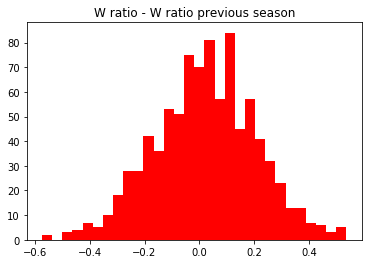

In [187]:
plt.hist(switched['season_W/L%_x']-switched['season_W/L%_y'], bins=30, color='red')
plt.title('RW ratio - W ratio previous season')
plt.savefig('plots/rv_dist.png')
plt.show()

In [134]:
switched['season_W/L%_x'].mean()

0.4952280311457178

In [136]:
switched['season_W/L%_y'].mean()

0.47376736996781443

# Place holder

In [131]:
class ModelP:
    def __init__(self,year):
        self.year=year
        self.X_train=pd.DataFrame()
        self.y_train=pd.DataFrame()
        self.X_test=pd.DataFrame()
        self.y_test=pd.DataFrame()
        self.label_train=np.array([])
        self.label_test=np.array([])
        self.y_pred=np.array([])
        self.rf_reg=RandomForestRegressor(max_depth=5, random_state=0,n_estimators=200)
        
    def fit(self,df): # creates clusters and sets up the data for the regression model
        df_train=df[df['Year_x']<self.year] #check if taking only the previous year preforms better?
        
        mini_train=MiniBatchKMeans(n_clusters=8, batch_size=100, random_state=4)
        X_cluster_train=df_train[['log_mean_ppg_y','ppg_y_std']]
        
        self.label_train=mini_train.fit_predict(X_cluster_train)

        df_train['label']=self.label_train
        df_train=pd.get_dummies(df_train,columns=['label'])
 
        df_year=df[df['Year_x']==self.year]
        mini=MiniBatchKMeans(n_clusters=8, batch_size=100, random_state=4)
        X_cluster_test=df_year[['log_mean_ppg_y','ppg_y_std']]
    
        self.label_test=mini.fit_predict(X_cluster_test)
        df_year['label']=self.label_test
        df_year=pd.get_dummies(df_year,columns=['label'])
        
        self.X_train=df_train[['Age_x','ppg_y','mean_ppg_y','log_mean_ppg_y','var_ppg_y','ppg_y_std','MP_y','FG%_y','FGA_y','eFG%_y','FT%_y','FTA_y','3P%_y','3PA_y','PF_y','label_0','label_1','label_2','label_3','label_4','label_5','label_6','label_7']]
        self.y_train=df_train[['ppg_x']]
        self.X_test=df_year[['Age_x','ppg_y','mean_ppg_y','log_mean_ppg_y','var_ppg_y','ppg_y_std','MP_y','FG%_y','FGA_y','eFG%_y','FT%_y','FTA_y','3P%_y','3PA_y','PF_y','label_0','label_1','label_2','label_3','label_4','label_5','label_6','label_7']]
        self.y_test=df_year[['ppg_x']]
        
    def model_predict(self,*args): # predicts the player ppg
        
        self.rf_reg.fit(self.X_train,self.y_train)
        self.y_pred=self.rf_reg.predict(self.X_test)
        if not args:
            return (self.y_pred)
        else:
            for arg in args:
    
    def score(self): # returns the MSE score for the model and for the benchmark model
        mse=mean_squared_error(self.y_test,self.y_pred)
        print('The MSE is : {}'.format(mse))
        
        benchmark_error=mean_squared_error(self.y_test,self.X_test['ppg_y'])
        print('The benchmark MSE is : {}'.format(benchmark_error))
        return (mse)
        
    def plots(self,plot_type='residuals'): # plots --> plot_type= 'residuals' or 'hist'
        
        hand={}
        self.y_pred.reshape(-1,1)
        temp=pd.DataFrame(index=self.y_test.index, columns=['y_test','y_pred','cluster'])
        temp['y_test']=self.y_test
        temp['y_pred']=self.y_pred
        temp['cluster']=self.label_test
        cmap={0:'red',1:'orange', 2:'green', 3:'blue', 4:'magenta',5:'cyan',6:'black',7:'forestgreen'}
        if plot_type=='residuals':
            for element in temp['cluster'].unique():
                class_temp=temp[temp['cluster']==element]
                hand[element]=plt.scatter(class_temp['y_test'].values,class_temp['y_test'].values-class_temp['y_pred'].values,alpha=0.6, color=cmap[element],marker='.' ,label='clusters {}'.format(element))
            plt.title('y_test vs residuals')
            plt.xlabel('y_test')
            plt.ylabel('residuals')
            plt.legend((hand[0],hand[1],hand[2],hand[3],hand[4],hand[5],hand[6],hand[7]), ('cluster 1','cluster 2','cluster 3','cluster 4','cluster 5','cluster 6','cluster 7'))
            plt.show()
        elif plot_type=='hist':
            fig,axis = plt.subplots(2,4, figsize=(15,10))
            axis=axis.ravel()
            for element in temp['cluster'].unique():
                class_temp=temp[temp['cluster']==element]
                axis[element].hist(class_temp['y_test'].values-class_temp['y_pred'].values, bins=10, color='orange')
                axis[element].set_title('cluster {} residuals'.format(element))
                axis[element].set_xlabel('residuals')
                axis[element].set_ylabel('count')
            plt.tight_layout()
            plt.show()

    def clusters(self): # get the clusters with the residuals and player names
        cluster={}
        clus_resids={}
        c_temp=pd.DataFrame(index=self.y_test.index, columns=['y_test','y_pred','cluster'])
        c_temp['y_test']=self.y_test
        c_temp['y_pred']=self.y_pred
        c_temp['resids']=c_temp['y_test']-c_temp['y_pred']
        c_temp['cluster']=self.label_test
        for clus in c_temp['cluster'].unique():
            cluster[clus]=c_temp[c_temp['cluster']==clus]
            clus_resids[clus]=(cluster[clus]['resids'].mean(),cluster[clus]['resids'].std())
        return cluster, clus_resids
        
    def importance(self): # permutation feature importance using rfpimp library
        imp =importances(self.rf_reg, self.X_test, self.y_test) 
        viz = plot_importances(imp,width=6, vscale=2)
        viz.view()
        print(imp)

IndentationError: expected an indented block (<ipython-input-131-ef982df02a85>, line 46)

The MSE is : 9.602701133445807
The benchmark MSE is : 10.53196412029064
The MSE is : 8.726737962515688
The benchmark MSE is : 9.13363981371178
The MSE is : 8.383274339098229
The benchmark MSE is : 9.26076507629748
The MSE is : 8.438594631086993
The benchmark MSE is : 10.373275438983228
The MSE is : 7.4674771986233734
The benchmark MSE is : 8.972459993683001

In [142]:
from scipy.stats import norm

In [158]:
cur=norm.pdf(switched['season_W/L%_x'],switched['season_W/L%_x'].mean(),switched['season_W/L%_x'].std())

In [145]:
prev=norm.pdf(switched['season_W/L%_y'])

In [168]:
x=np.linspace(switched['season_W/L%_x'].min(),switched['season_W/L%_x'].max(),899)

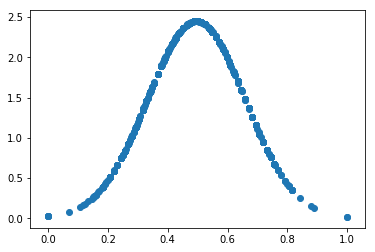

In [171]:
plt.scatter(switched['season_W/L%_x'],cur)

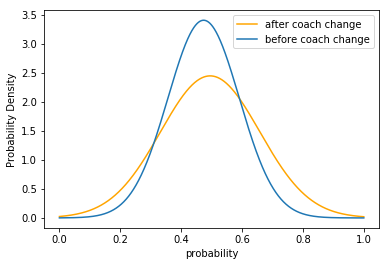

In [186]:
x=np.linspace(np.min(switched['season_W/L%_x']), np.max(switched['season_W/L%_x']), 5000)
mu = switched['season_W/L%_x'].mean()
mu2=switched['season_W/L%_y'].mean()
stdev = switched['season_W/L%_x'].std()
stdev2=switched['season_W/L%_y'].std()
ndist2=norm.pdf(x,mu2,stdev2)
ndist=norm.pdf(x, mu, stdev)
plt.plot(x, ndist, c='orange', label='after coach change')
plt.plot(x,ndist2,  label= 'before coach change')
plt.xlabel('probability')
plt.ylabel('Probability Density')
plt.legend()
plt.legend()
plt.savefig('plots/Hypo_dist')
plt.show()

(array([  6.,  25.,  90., 132., 151., 237., 175.,  69.,  12.,   2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

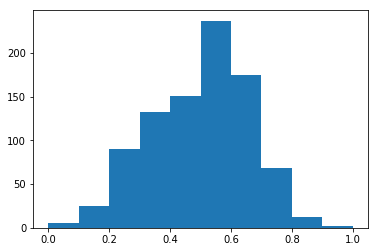

In [163]:
plt.hist(switched['season_W/L%_x'])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  2.,
         1.,  2.,  1.,  4.,  2.,  1.,  2.,  3.,  8.,  4.,  1.,  5.,  7.,
        12., 16.,  8.,  9.,  9., 19., 13., 15., 17., 17., 13., 23., 22.,
        12., 30., 27., 28., 38., 25., 18., 27., 34., 29., 33., 34., 24.,
        26., 29., 16., 30., 18., 23., 23., 20., 23., 12., 13., 14., 16.,
         5.,  6.,  7.,  3.,  4.,  6.,  2.,  2.,  1.]),
 array([0.24197072, 0.24353534, 0.24509996, 0.24666458, 0.24822919,
        0.24979381, 0.25135843, 0.25292305, 0.25448766, 0.25605228,
        0.2576169 , 0.25918152, 0.26074613, 0.26231075, 0.26387537,
        0.26543999, 0.2670046 , 0.26856922, 0.27013384, 0.27169846,
        0.27326307, 0.27482769, 0.27639231, 0.27795692, 0.27952154,
        0.28108616, 0.28265078, 0.28421539, 0.28578001, 0.28734463,
        0.28890925, 0.2904

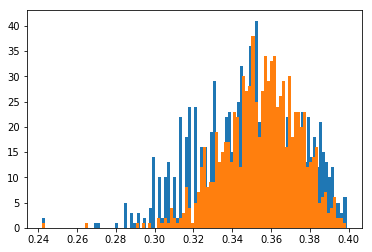

In [155]:
plt.hist(cur, bins=100)
plt.hist(prev, bins=100)

In [152]:
x=np.linspace(0,1,899)